In [1]:
# label wdpa_pids as (trend: sig_increase, sig_decrease, no_change, increase, decrease) across all years
# IGNORE figure 1: methods figure of transect idea
# IGNORE figure 2: map of trend. (join spatial information)
# IGNORE figure 2a: sub image of 4 examples 2020 magnitude_gradient image, ndvi_image, raw satellite image; find most edgey ones but for built, vegetation, elevation, water

In [2]:
# figure 3: calculate edge extent as sig_increase, sig_decrease, no_change, increase, decrease, across all years then pool edge_extent by biome in a vertical stacked bar chart showing significant increase, significant decrease, no change, count of WDPA_PID by biome below biome name and % of each category labeled
# figure 4a: edge_extent ~ AREA_DISSO + gHM_mean + ndvi_mean + elevation_mean + slope_mean + water_extent + (1|biome + year)
#           plot this to show relationship between edge_extent and the covariates
# figure 4b: edge_intensity ~ AREA_DISSO + gHM_mean + ndvi_mean + elevation_mean + slope_mean + water_extent + (1|biome + year)
#           plot this to show relationship between edge_intensity and the covariates
# anova for IUCN_CAT, STATUS_YR, biome, AREA_DISSO to check influence
# figure S1: overall distribution of edge_extent and edge_intensity
# figure S2: correlation plot of edge_intensity vs edge_extent

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# ===== CONFIGURATION: SELECT INDEX =====
INDEX_NAME = 'lai'  # Must match the index processed
# =======================================

print(f"Loading {INDEX_NAME.upper()} analysis data...")

# Load index-specific data
wdpa_df = pd.read_parquet(f"../results/wdpa_df_{INDEX_NAME}.parquet")
wdpa_df = wdpa_df[wdpa_df['year'] == 2020]
print(f"Loaded {len(wdpa_df):,} rows for {len(wdpa_df['WDPA_PID'].unique())} protected areas")

# Recategorize BIOME_NAME
def recategorize_biome(biome):
    if biome == "Mangroves":
        return "Mangrove"
    elif biome == "N/A":
        return "Rock & Ice"
    elif biome in ["Deserts & Xeric Shrublands"]:
        return "Desert"
    elif biome in ["Tropical & Subtropical Coniferous Forests",
                   "Tropical & Subtropical Moist Broadleaf Forests",
                   "Tropical & Subtropical Dry Broadleaf Forests"]:
        return "Tropical-Forests"
    elif biome in ["Mediterranean Forests, Woodlands & Scrub",
                   "Temperate Conifer Forests",
                   "Temperate Broadleaf & Mixed Forests"]:
        return "Temperate-Forests"
    elif biome in ["Boreal Forests/Taiga"]:
        return "Boreal-Forests"
    elif biome in ["Tropical & Subtropical Grasslands, Savannas & Shrublands",
                   "Temperate Grasslands, Savannas & Shrublands",
                   "Montane Grasslands & Shrublands",
                   "Flooded Grasslands & Savannas"]:
        return "Grassland-Shrubland"
    else:
        return biome

wdpa_df['BIOME_NAME'] = wdpa_df['BIOME_NAME'].apply(recategorize_biome)

# Calculate trend for each WDPA_PID using linear regression
def classify_trend(group):
    X = group['year'].values
    y = group['edge_extent'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    
    if p_value < 0.05:
        if slope > 0:
            return 'sig_increase'
        else:
            return 'sig_decrease'
    else:
        if slope > 0:
            return 'increase'
        elif slope < 0:
            return 'decrease'
        else:
            return 'no_change'

trend_df = wdpa_df.groupby('WDPA_PID').apply(classify_trend).reset_index()
trend_df.columns = ['WDPA_PID', 'trend']

# Merge trend back to wdpa_df
wdpa_df = wdpa_df.merge(trend_df, on='WDPA_PID', how='left')

print(f"Trend distribution:\n{wdpa_df.groupby('WDPA_PID')['trend'].first().value_counts()}")

Loading LAI analysis data...
Loaded 3,786 rows for 3786 protected areas


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_56142/2032378115.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = wdpa_df.groupby('WDPA_PID').apply(classify_trend).reset_index()


Trend distribution:
trend
no_change    3786
Name: count, dtype: int64


In [4]:
wdpa_df.head()

,WDPA_PID,year,n_trnst,D02,D01,D0m1,D0m2,edge_intensity,edge_extent,gHM_mean,...,slope_mean,water_extent_pct,ORIG_NAME,ISO3,PERIMETER,AREA_DISSO,IUCN_CAT,STATUS_YR,BIOME_NAME,trend
0,100017,2020,547,0.028537,-0.014885,0.277358,0.386694,-0.014885,0.305302,1.733793e-01,...,3.183144,8.226691,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,no_change
1,100204,2020,171,-0.197922,-0.022296,-0.057947,-0.240572,-0.240572,0.432749,1.683704e-05,...,0.928757,8.771930,Amisk Park Reserve,CAN,278692.566815,1.974718e+09,Ib,1995,Boreal-Forests,no_change
2,100205,2020,367,-0.234474,-0.112807,-0.125435,-0.189088,-0.234474,0.024523,7.392102e-09,...,0.602049,30.245232,Caribou River Provincial Park,CAN,464945.969731,7.612777e+09,Ib,1995,Boreal-Forests,no_change
3,100206,2020,257,0.074651,0.015876,-0.115833,-0.033178,-0.115833,0.241245,0.000000e+00,...,0.501245,9.727626,Numaykoos Lake Provincial Park,CAN,305763.176205,3.594642e+09,Ib,1995,Boreal-Forests,no_change
4,100285,2020,244,-0.810381,-0.645874,-0.737990,-0.622803,-0.810381,0.147541,3.596484e-02,...,13.634503,3.688525,Stein Valley Nlaka'Pamux Heritage Park,CAN,219828.467688,1.083194e+09,II,1995,Temperate-Forests,no_change


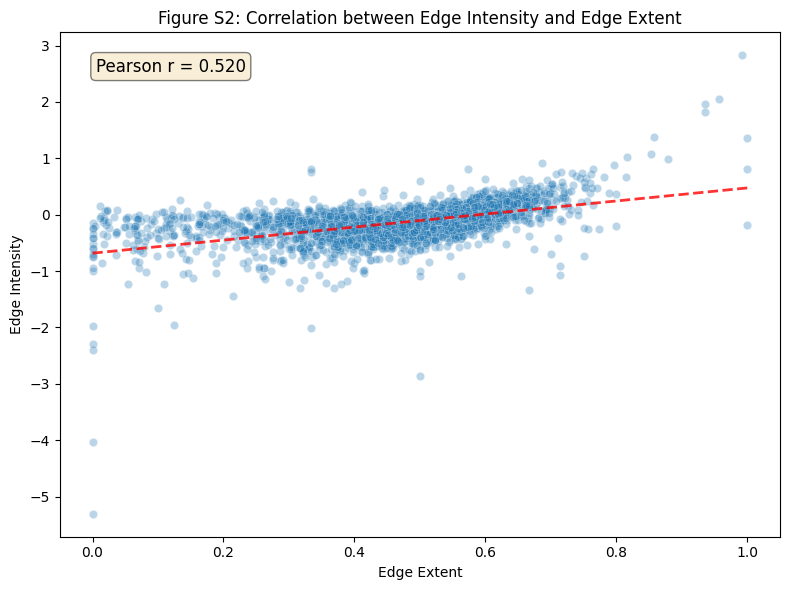

In [5]:
# Figure S2: Correlation between edge_intensity and edge_extent
# Filter out infinite values
wdpa_clean = wdpa_df[np.isfinite(wdpa_df['edge_extent']) & np.isfinite(wdpa_df['edge_intensity'])]

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with density
sns.scatterplot(data=wdpa_clean, x='edge_extent', y='edge_intensity', alpha=0.3, ax=ax)

# Add correlation
corr = wdpa_clean[['edge_extent', 'edge_intensity']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'Pearson r = {corr:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add regression line
z = np.polyfit(wdpa_clean['edge_extent'], wdpa_clean['edge_intensity'], 1)
p = np.poly1d(z)
x_line = np.linspace(wdpa_clean['edge_extent'].min(), wdpa_clean['edge_extent'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

ax.set_xlabel('Edge Extent')
ax.set_ylabel('Edge Intensity')
ax.set_title('Figure S2: Correlation between Edge Intensity and Edge Extent')
plt.tight_layout()
plt.savefig(f'../results/figs/{INDEX_NAME}_figureS2_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


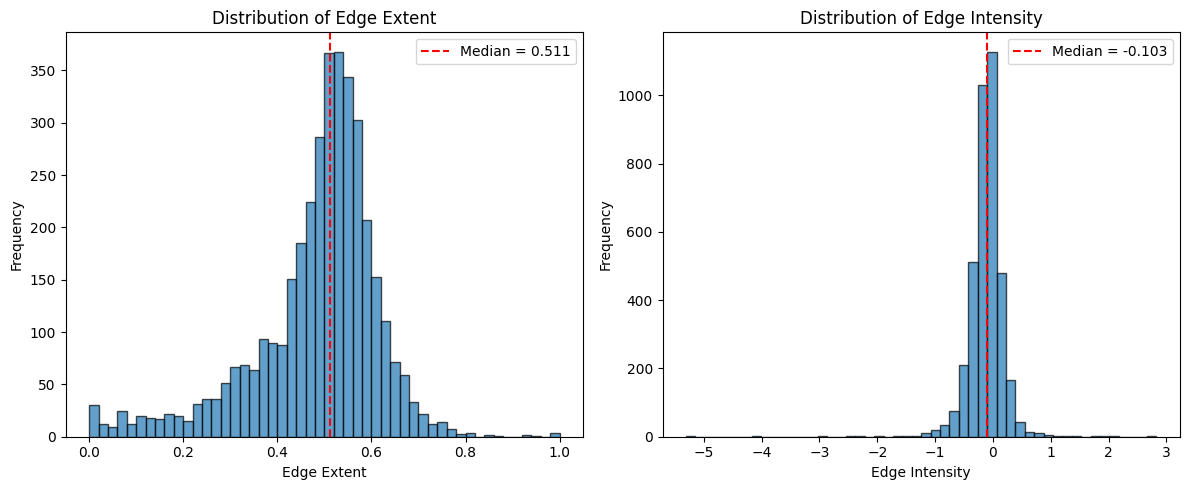

In [6]:
# Figure S1: Distribution of edge_extent and edge_intensity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Filter out infinite values
wdpa_clean = wdpa_df[np.isfinite(wdpa_df['edge_extent']) & np.isfinite(wdpa_df['edge_intensity'])]

# Edge extent distribution
axes[0].hist(wdpa_clean['edge_extent'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(wdpa_clean['edge_extent'].median(), color='red', linestyle='--', 
                label=f'Median = {wdpa_clean["edge_extent"].median():.3f}')
axes[0].set_xlabel('Edge Extent')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Edge Extent')
axes[0].legend()

# Edge intensity distribution
axes[1].hist(wdpa_clean['edge_intensity'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(wdpa_clean['edge_intensity'].median(), color='red', linestyle='--',
                label=f'Median = {wdpa_clean["edge_intensity"].median():.3f}')
axes[1].set_xlabel('Edge Intensity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Edge Intensity')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'../results/figs/{INDEX_NAME}_figureS1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# ANOVA for categorical predictors
anova_df = wdpa_df[['edge_extent', 'IUCN_CAT', 'STATUS_YR', 'BIOME_NAME', 'AREA_DISSO']].dropna()

# IUCN_CAT
model_iucn = ols('edge_extent ~ C(IUCN_CAT)', data=anova_df).fit()
print("ANOVA for IUCN_CAT:")
print(anova_lm(model_iucn, typ=2))
print("\n")

# STATUS_YR
model_status = ols('edge_extent ~ STATUS_YR', data=anova_df).fit()
print("ANOVA for STATUS_YR:")
print(anova_lm(model_status, typ=2))
print("\n")

# biome
model_biome = ols('edge_extent ~ C(BIOME_NAME)', data=anova_df).fit()
print("ANOVA for biome:")
print(anova_lm(model_biome, typ=2))
print("\n")

# AREA_DISSO
model_area = ols('edge_extent ~ AREA_DISSO', data=anova_df).fit()
print("ANOVA for AREA_DISSO:")
print(anova_lm(model_area, typ=2))

ANOVA for IUCN_CAT:
                sum_sq      df          F        PR(>F)
C(IUCN_CAT)   2.624780     9.0  15.339567  7.903416e-25
Residual     71.657796  3769.0        NaN           NaN


ANOVA for STATUS_YR:
              sum_sq      df         F    PR(>F)
STATUS_YR   0.159862     1.0  8.145954  0.004339
Residual   74.122713  3777.0       NaN       NaN


ANOVA for biome:
                  sum_sq      df           F         PR(>F)
C(BIOME_NAME)  17.210664     7.0  162.455231  1.816787e-210
Residual       57.071912  3771.0         NaN            NaN


ANOVA for AREA_DISSO:
               sum_sq      df          F        PR(>F)
AREA_DISSO   0.581862     1.0  29.819149  5.048362e-08
Residual    73.700714  3777.0        NaN           NaN


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: edge_intensity
No. Observations: 3512    Method:             REML          
No. Groups:       8       Scale:              nan           
Min. group size:  7       Log-Likelihood:     nan           
Max. group size:  1236    Converged:          No            
Mean group size:  439.0                                     
-------------------------------------------------------------
                    Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept                                                    
AREA_DISSO_z                                                 
gHM_mean_z                                                   
elevation_mean_z                                             
slope_mean_z                                                 
water_extent_pct_z                                           
Group Var                  

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:508: RuntimeWarning: invalid value encountered in subtract
  return rhs / s - ql / s**2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/linalg/_linalg.py:2325: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

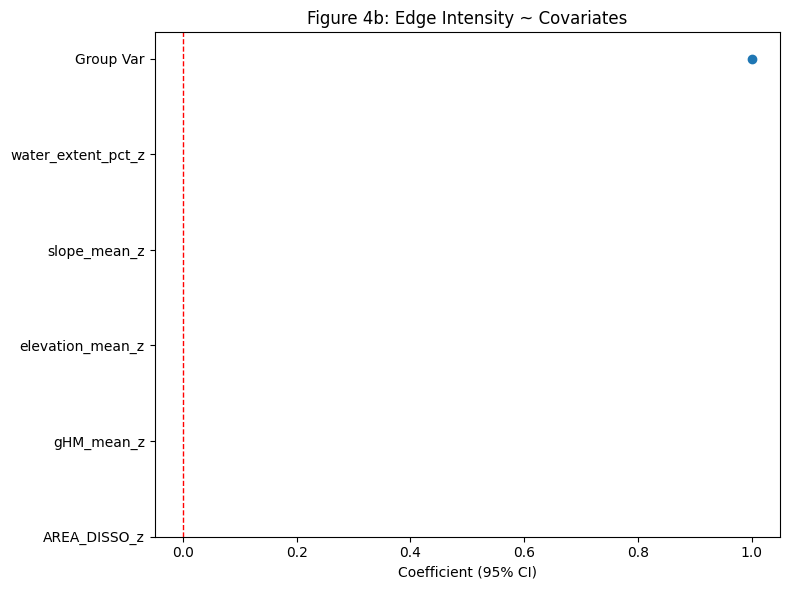

In [8]:
# Figure 4b: Mixed model for edge_intensity
model_df2 = wdpa_df[['edge_intensity', 'AREA_DISSO', 'gHM_mean', 'elevation_mean', 
                      'slope_mean', 'water_extent_pct', 'BIOME_NAME', 'year', 'WDPA_PID']].dropna()

# Standardize continuous predictors
for col in ['AREA_DISSO', 'gHM_mean', 'elevation_mean', 'slope_mean', 'water_extent_pct']:
    model_df2[f'{col}_z'] = (model_df2[col] - model_df2[col].mean()) / model_df2[col].std()

# Fit mixed model with biome as random effect
md2 = MixedLM.from_formula(
    'edge_intensity ~ AREA_DISSO_z + gHM_mean_z + elevation_mean_z + slope_mean_z + water_extent_pct_z',
    data=model_df2,
    groups=model_df2['BIOME_NAME'],
    re_formula='1'
)
mdf2 = md2.fit()
print(mdf2.summary())

# Save model summary to file
with open(f'../results/figs/{INDEX_NAME}_edge_intensity_model.txt', 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("MIXED MODEL: EDGE INTENSITY\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(mdf2.summary()))

# Plot coefficients
coef_df2 = pd.DataFrame({
    'Variable': mdf2.params.index[1:],
    'Coefficient': mdf2.params.values[1:],
    'CI_lower': mdf2.conf_int().iloc[1:, 0],
    'CI_upper': mdf2.conf_int().iloc[1:, 1]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(coef_df2['Coefficient'], range(len(coef_df2)), 
            xerr=[coef_df2['Coefficient'] - coef_df2['CI_lower'], 
                  coef_df2['CI_upper'] - coef_df2['Coefficient']],
            fmt='o', capsize=5)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_yticks(range(len(coef_df2)))
ax.set_yticklabels(coef_df2['Variable'])
ax.set_xlabel('Coefficient (95% CI)')
ax.set_title('Figure 4b: Edge Intensity ~ Covariates')
plt.tight_layout()
plt.savefig(f'../results/figs/{INDEX_NAME}_figure4b_edge_intensity_model.png', dpi=300, bbox_inches='tight')
plt.show()


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  edge_extent
No. Observations:   3529     Method:              REML       
No. Groups:         8        Scale:               0.0137     
Min. group size:    8        Log-Likelihood:      2518.9698  
Max. group size:    1238     Converged:           Yes        
Mean group size:    441.1                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.444    0.041 10.939 0.000  0.364  0.523
AREA_DISSO_z       -0.003    0.002 -1.523 0.128 -0.007  0.001
gHM_mean_z          0.016    0.002  7.572 0.000  0.012  0.021
elevation_mean_z   -0.023    0.003 -7.933 0.000 -0.028 -0.017
slope_mean_z       -0.010    0.003 -3.273 0.001 -0.015 -0.004
water_extent_pct_z -0.001    0.002 -0.317 0.751 -0.005  0.003
Group Var           

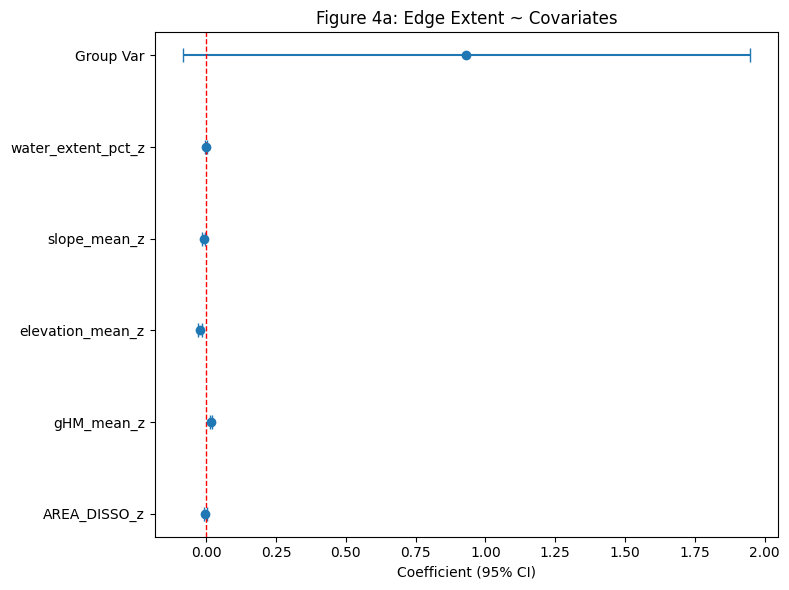

In [9]:
# Figure 4a: Mixed model for edge_extent
model_df = wdpa_df[['edge_extent', 'AREA_DISSO', 'gHM_mean', 'elevation_mean', 
                     'slope_mean', 'water_extent_pct', 'BIOME_NAME', 'year', 'WDPA_PID']].dropna()

# Standardize continuous predictors
for col in ['AREA_DISSO', 'gHM_mean', 'elevation_mean', 'slope_mean', 'water_extent_pct']:
    model_df[f'{col}_z'] = (model_df[col] - model_df[col].mean()) / model_df[col].std()

# Fit mixed model with biome as random effect
md = MixedLM.from_formula(
    'edge_extent ~ AREA_DISSO_z + gHM_mean_z + elevation_mean_z + slope_mean_z + water_extent_pct_z',
    data=model_df,
    groups=model_df['BIOME_NAME'],
    re_formula='1'
)
mdf = md.fit()
print(mdf.summary())

# Save model summary to file
with open(f'../results/figs/{INDEX_NAME}_edge_extent_model.txt', 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("MIXED MODEL: EDGE EXTENT\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(mdf.summary()))

# Plot coefficients
coef_df = pd.DataFrame({
    'Variable': mdf.params.index[1:],  # Skip intercept
    'Coefficient': mdf.params.values[1:],
    'CI_lower': mdf.conf_int().iloc[1:, 0],
    'CI_upper': mdf.conf_int().iloc[1:, 1]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(coef_df['Coefficient'], range(len(coef_df)), 
            xerr=[coef_df['Coefficient'] - coef_df['CI_lower'], 
                  coef_df['CI_upper'] - coef_df['Coefficient']],
            fmt='o', capsize=5)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_yticks(range(len(coef_df)))
ax.set_yticklabels(coef_df['Variable'])
ax.set_xlabel('Coefficient (95% CI)')
ax.set_title('Figure 4a: Edge Extent ~ Covariates')
plt.tight_layout()
plt.savefig(f'../results/figs/{INDEX_NAME}_figure4a_edge_extent_model.png', dpi=300, bbox_inches='tight')
plt.show()


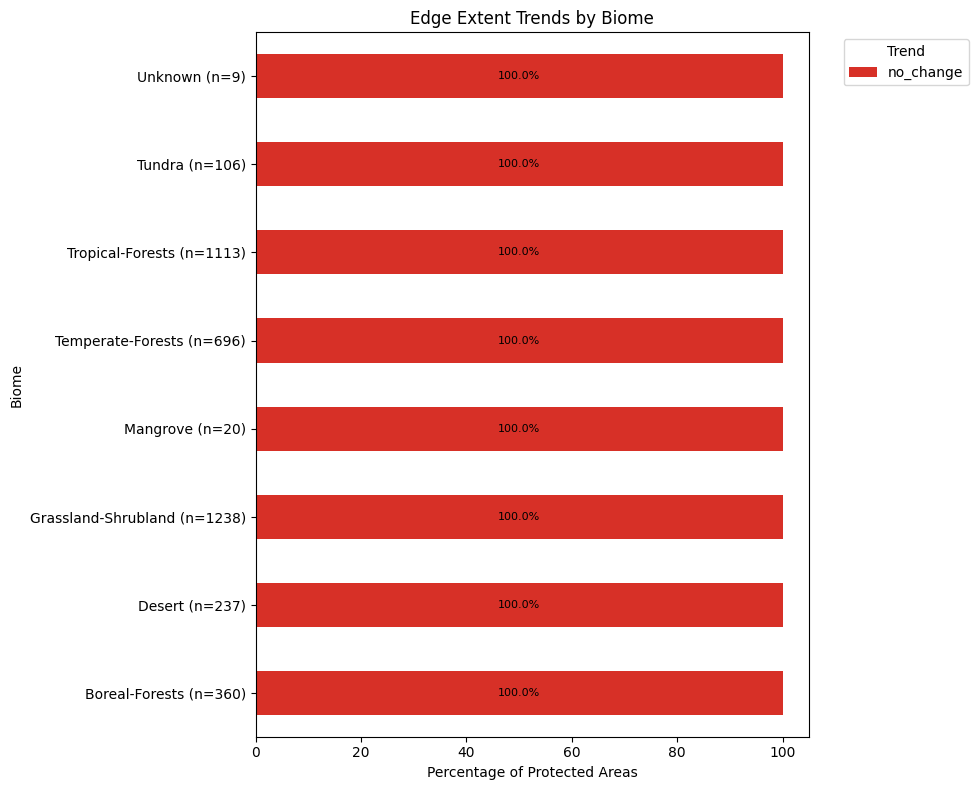

In [10]:
# Figure 3: Stacked bar chart of trend by biome (horizontal)
trend_by_biome = wdpa_df.groupby(['BIOME_NAME', 'WDPA_PID'])['trend'].first().reset_index()
trend_counts = trend_by_biome.groupby(['BIOME_NAME', 'trend']).size().unstack(fill_value=0)

# Reorder columns
col_order = ['sig_decrease', 'decrease', 'no_change', 'increase', 'sig_increase']
trend_counts = trend_counts[[c for c in col_order if c in trend_counts.columns]]

# Calculate percentages
trend_pcts = trend_counts.div(trend_counts.sum(axis=1), axis=0) * 100

# Plot horizontal
fig, ax = plt.subplots(figsize=(10, 8))
trend_pcts.plot(kind='barh', stacked=True, ax=ax, 
                color=['#d73027', '#fc8d59', "#afab9e", '#91bfdb', '#4575b4'])

# Add count labels after biome names
biome_counts = trend_counts.sum(axis=1)
ax.set_yticklabels([f"{biome} (n={biome_counts[biome]})" for biome in trend_pcts.index])

# Add percentage labels on bars
for i, biome in enumerate(trend_pcts.index):
    cumulative = 0
    for col in trend_pcts.columns:
        val = trend_pcts.loc[biome, col]
        if val > 5:  # Only label if > 5%
            ax.text(cumulative + val/2, i, f'{val:.1f}%', 
                   ha='center', va='center', fontsize=8)
        cumulative += val

ax.set_xlabel('Percentage of Protected Areas')
ax.set_ylabel('Biome')
ax.legend(title='Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Edge Extent Trends by Biome')
plt.tight_layout()
plt.savefig(f'../results/figs/{INDEX_NAME}_figure3_trends_by_biome.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Summary Statistics
output_lines = []
output_lines.append("=" * 60)
output_lines.append("SUMMARY STATISTICS")
output_lines.append("=" * 60)

# Total unique WDPA_PIDs
n_wdpa = wdpa_df['WDPA_PID'].nunique()
output_lines.append(f"Total number of unique WDPA_PID: {n_wdpa:,}")

# Total transects (sum of n_trnst)
total_transects = wdpa_df.groupby('WDPA_PID')['n_trnst'].first().sum()
output_lines.append(f"Total number of transects: {total_transects:,}")

# Total unique ISO3
n_iso3 = wdpa_df['ISO3'].nunique()
output_lines.append(f"Total number of unique ISO3: {n_iso3:,}")

# Total unique biomes
n_biome = wdpa_df['BIOME_NAME'].nunique()
output_lines.append(f"Total number of unique biome: {n_biome:,}")

# Number of WDPA_PID per biome
output_lines.append("\nNumber of WDPA_PID per biome:")
biome_counts = wdpa_df.groupby('BIOME_NAME')['WDPA_PID'].nunique().sort_values(ascending=False)
for biome, count in biome_counts.items():
    output_lines.append(f"  {biome}: {count:,}")

# Trend distribution
output_lines.append("\nTrend distribution:")
trend_counts = wdpa_df.groupby('WDPA_PID')['trend'].first().value_counts()
for trend, count in trend_counts.items():
    output_lines.append(f"  {trend}: {count:,}")

# Edge extent < 10%
wdpa_summary = wdpa_df.groupby('WDPA_PID').agg({
    'edge_extent': 'mean',
    'edge_intensity': 'mean'
}).reset_index()

low_extent = (wdpa_summary['edge_extent'] < 0.1).sum()
low_extent_pct = (low_extent / len(wdpa_summary)) * 100
output_lines.append(f"\nWDPA_PID with edge_extent < 10%: {low_extent:,} ({low_extent_pct:.1f}%)")

# Edge intensity < 0
low_intensity = (wdpa_summary['edge_intensity'] < 0).sum()
low_intensity_pct = (low_intensity / len(wdpa_summary)) * 100
output_lines.append(f"WDPA_PID with edge_intensity < 0: {low_intensity:,} ({low_intensity_pct:.1f}%)")
output_lines.append("=" * 60)

# Print to console
print('\n'.join(output_lines))

# Save to file
with open(f'../results/figs/{INDEX_NAME}_summary_statistics.txt', 'w') as f:
    f.write('\n'.join(output_lines))


SUMMARY STATISTICS
Total number of unique WDPA_PID: 3,786
Total number of transects: 1,353,903
Total number of unique ISO3: 140
Total number of unique biome: 8

Number of WDPA_PID per biome:
  Grassland-Shrubland: 1,238
  Tropical-Forests: 1,113
  Temperate-Forests: 696
  Boreal-Forests: 360
  Desert: 237
  Tundra: 106
  Mangrove: 20
  Unknown: 9

Trend distribution:
  no_change: 3,786

WDPA_PID with edge_extent < 10%: 110 (2.9%)
WDPA_PID with edge_intensity < 0: 2,682 (70.8%)
